<a href="https://colab.research.google.com/github/astrapi69/DroidBallet/blob/master/Kopie_von_DLG_D5_E1_Introduction_to_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><a target="_blank" href="https://academy.constructor.org/"><img src="https://jobtracker.ai/static/media/constructor_academy_colour.b86fa87f.png" width="200" style="background:none; border:none; box-shadow:none;" /></a> </center>

_____
<center> <h1>  </h1> </center>
<center>Constructor Academy, 2024</center>

# Grad-CAM (Helper Notebook)

##  Grad-CAM: Understanding CNN layers

__Part 1: An introduction to Grad-CAM__



## Introduction


Grad-CAM is an algorithm proposed by the paper `Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization` https://arxiv.org/abs/1610.02391. It's a very useful tool for understanding deep CNN models better and being able to improve them. It is a class-discriminative localization technique that generates visual explanations for any CNN-based network without requiring architectural changes or re-training. The image below is an overview of how Grad-CAM highlights signals picked up by our model.


<img src="https://drive.google.com/uc?id=16q2Z-_oDr_eBIkskc_MrBLC_bEa7IhdY" width=1500 class="center">

With Grad-CAM we can:
- understand the reason behind wrong predictions.
- identify biases in datasets.
- discern a ‘stronger’ network from a ‘weaker’ one, even when both make identical prediction.

In order to obtain the class-discriminative localization map Grad-CAM, we first compute the gradient of the scores for each class, with respect to the feature map activations of a convolutional layer. These gradients are then used to obtain the neuron importance of the weights.

For more theoretical understanding, please refer to the links below:
- https://arxiv.org/pdf/1610.02391.pdf
- https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning


Grad-CAM gained very recently attention and is for example part of the `tf-explain` package: https://tf-explain.readthedocs.io/en/latest/index.html.



## Task


- Follow along with this guided tutorial understanding the key code snippets involved in the Grad-CAM methodology
- We provide you with a notebook that already can be run in Google Colab.
- Test Grad-CAM on the provided example images.
- Search for more images in the web that might challenge the network, like a cat and a dog in the same picture.
- Compare the performance of different pretrained networks (VGG, ResNet-50, ...). Do you see differences in the performances? Can you find obvious errors which are probably caused by bias in the training data?


Grad-CAM works by
1. finding the final convolutional layer in the network
2. examining the gradient information flowing into that layer

The output of Grad-CAM is a heatmap visualization for a given class label (either the top, predicted label or an arbitrary label we select for debugging).

We can use this heatmap to __visually verify__ where in the image the CNN is looking.

## Utility functions

In [ ]:
from functools import wraps

# function to add class methods dynamically
def add_method(cls):
    def decorator(func):
        @wraps(func)
        def wrapper(self, *args, **kwargs):
            return func(self, *args, **kwargs)
        setattr(cls, func.__name__, wrapper)
        # Note we are not binding func, but wrapper which accepts self but does exactly the same as func
        return func # returning func means func can still be used normally
    return decorator

## Building GradCAM

## Import libraries

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2 # open cv

## Create an empty GradCAM Class

We will add functionality to this empty class step by step with detailed info about each function

In [ ]:
class GradCAM:
    pass

## Creating the Constructor

The constructor accepts and stores:

- A TensorFlow model which we’ll use to compute a heatmap
- The classIdx — a specific class index that we’ll use to measure our class activation heatmap
- An optional CONV layerName of the model in case we want to visualize the heatmap of a specific layer of our CNN; otherwise, if a specific layer name is not provided, we will automatically infer on the final CONV/POOL layer of the model architecture

In [ ]:
@add_method(GradCAM)
def __init__(self, model, classIdx, layerName=None):

    # store the model, the class index used to measure the class
    # activation map, and the layer to be used when visualizing
    # the class activation map
    self.model = model
    self.classIdx = classIdx
    self.layerName = layerName

    # if the layer name is None, attempt to automatically find
    # the target output layer
    if self.layerName is None:
        self.layerName = self.find_target_layer()

## Adding function to find target layer

The `find_target_layer()` function loops over all layers in the network in reverse order, during which time it checks to see if the current layer has a 4D output (implying a CONV or POOL layer).

If find such a 4D output, we return that layer name.

Otherwise, if the network does not have a 4D output, then we cannot apply Grad-CAM, at which point, we raise a ValueError exception, causing our program to stop

In [ ]:
@add_method(GradCAM)
def find_target_layer(self):

    # attempt to find the final convolutional layer in the network
    # by looping over the layers of the network in reverse order
    for layer in reversed(self.model.layers):
        # check to see if the layer has a 4D output
        if len(layer.output_shape) == 4:
            return layer.name

    # otherwise, we could not find a 4D layer so the GradCAM
    # algorithm cannot be applied
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

## Adding function to construct GradCAM heatmap

The compute_heatmap method, which is the heart of our Grad-CAM model. Let’s take this implementation one step at a time to learn how it works.

<br/>

__Step 1:__

Our Grad-CAM requires that we pass in the image for which we want to visualize class activations mappings for.

From there, we construct our gradModel, which consists of both an input and an output:

- inputs: The standard image input to the model
- outputs: The outputs of the layerName class attribute used to generate the class activation mappings.

Notice how we call `get_layer()` on the model itself while also grabbing the output of that specific layer.

<br/>

__Step 2:__

Once our gradient model is constructed, we’ll proceed to compute gradients.

Going forward, we need to understand the definition of automatic differentiation and what TensorFlow calls a gradient tape.

_Automatic differentiation_ is the process of computing a value and computing derivatives of that value.

> _TensorFlow provides the `tf.GradientTape` API for automatic differentiation — computing the gradient of a computation with respect to its input variables. TensorFlow “records” all operations executed inside the context of a `tf.GradientTape` onto a “tape”. TensorFlow then uses that tape and the gradients associated with each recorded operation to compute the gradients of a “recorded” computation using reverse mode differentiation ([TensorFlow’s Automatic differentiation and gradient tape Tutorial](https://www.tensorflow.org/tutorials/customization/autodiff))_

- In this step, we accept the input image and cast it to a 32-bit floating point type
- A forward pass through the gradient model produces the convOutputs and predictions of the layerName layer
- We then extract the loss associated with our predictions and specific classIdx we are interested in. Notice that our inference stops at the specific layer we are concerned about. We do not need to compute a full forward pass
- Finally we use automatic differentiation to compute the gradients that we will call grads

<br/>

__Step 3:__

Given our gradients, we’ll now compute guided gradients

First, we find all outputs and gradients with a value > 0 and cast them from a binary mask to a 32-bit floating point data type

Then we compute the guided gradients by multiplication

Keep in mind that both `castConvOutputs` and `castGrads` contain only values of 1’s and 0’s; therefore, during this multiplication if any of `castConvOutputs`, `castGrads`, and `grads` are zero, then the output value for that particular index in the volume will be zero.

Essentially, what we are doing here is finding positive values of both `castConvOutputs` and `castGrads`, followed by multiplying them by the gradient of the differentiation — this operation will allow us to visualize where in the volume the network is activating __(i.e highlight regions of the image \ feature map being activated based on the guided gradients)__

The convolution and guided gradients have a batch dimension that we don’t need, hence we discard it.

<br/>

__Step 4:__

Here. we compute the weights of the gradient values by computing the mean of `guidedGrads`, which is essentially a 1 x 1 x N average across the volume.

We then take those weights and sum the ponderated (i.e., mathematically weighted) maps into the Grad-CAM visualization (`cam`).

<br/>

__Step 5:__

Our final step is to generate the output heatmap associated with our image.

We grab the original dimensions of input image and scale our `cam` mapping to the original image dimensions.

From there, we perform min-max rescaling to the range [0, 1] and then convert the pixel values back to the range [0, 255].

Finally, the last step of our `compute_heatmap()` method returns the heatmap to the caller.



In [ ]:
@add_method(GradCAM)
def compute_heatmap(self, image, eps=1e-8, verbose=False):

    # Step 1:
    # construct our gradient model by supplying
    # (1) the inputs to our pre-trained model
    # (2) the output of the (presumably) final 4D layer in the network
    # (3) the output of the softmax activations from the model
    gradModel = Model(
        inputs=[self.model.inputs],
        outputs=[self.model.get_layer(self.layerName).output,
            self.model.output])
    if verbose:
        print('\nStep 1:')
        print('Model:', self.model.name)
        print('Conv layerName:', self.layerName)
        print('Conv Layer Shape:', gradModel.outputs[0].shape)


    # Step 2:
    # record operations for automatic differentiation
    with tf.GradientTape() as tape:

        # cast the image tensor to a float-32 data type, pass the
        # image through the gradient model, and grab the loss
        # associated with the specific class index
        inputs = tf.cast(image, tf.float32)
        (convOutputs, predictions) = gradModel(inputs)
        loss = predictions[:, self.classIdx]

    # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    if verbose:
        print('\nStep 2:')
        print('loss:', loss)
        print('convOutputs shape;', convOutputs.shape)
        print('gradients shape:', grads.shape)


    # Step 3:
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    if verbose:
        print('\nStep 3')
        print('guidedGrads shape', guidedGrads.shape)

    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    if verbose:
        print('guidedGrads shape batch removal', guidedGrads.shape)
        print('convOutputs shape batch removal', convOutputs.shape)


    # Step 4:
    # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    if verbose:
        print('\nStep 4:')
        print('weights shape:', weights.shape)
        print('cam shape:', cam.shape)


    # Step 5:
    # grab the spatial dimensions of the input image and resize
    # the output class activation map to match the input image
    # dimensions
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h),
                         interpolation=cv2.INTER_CUBIC)

    # normalize the heatmap such that all values lie in the range
    # [0, 1], scale the resulting values to the range [0, 255],
    # and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
    if verbose:
        print('\nStep 5:')
        print('heatmap shape:', heatmap.shape)

    # return the resulting heatmap to the calling function
    return heatmap

## Adding function to overlay heatmap on the image

Our heatmap produced by the previous compute_heatmap function is a single channel, grayscale representation of where the network activated in the image — larger values correspond to a higher activation, smaller values to a lower activation.

In order to overlay the heatmap, we first need to apply a pseudo/false-color to the heatmap. To do so, we will use OpenCV’s built in `VIRIDIS` colormap (i.e., `cv2.COLORMAP_VIRIDIS`).

In [ ]:
@add_method(GradCAM)
def overlay_heatmap(self, heatmap, image, alpha=0.5,
                    colormap=cv2.COLORMAP_JET):

    # apply the supplied color map to the heatmap and then
    # overlay the heatmap on the input image
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

    # return a 2-tuple of the color mapped heatmap and the output,
    # overlaid image
    return (heatmap, output)

## Applying GradCAM

## Import libraries

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Load Pre-trained Models

In [ ]:
vgg_model = VGG16(weights='imagenet')
vgg_pre_process_fn = tf.keras.applications.vgg16.preprocess_input

resnet50_model = ResNet50(weights='imagenet')
resnet50_pre_process_fn = tf.keras.applications.resnet50.preprocess_input

102967424/102967424 [==============================] - 0s 0us/step


## Helper Functions - Image Utilities

In [ ]:
# helper function for image pre-processing
def image_processing_function(im_path, input_img_dims, pre_process_function):
  # load the original image from gdrive (in OpenCV format)
  # resize the image to its target dimensions

  # orig = cv2.imread(im_path)
  # orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
  orig = load_img(im_path)
  orig_arr = img_to_array(orig).astype("uint8")

  # load the input image from gdrive (in Keras/TensorFlow format)
  # basic image pre-processing

  image = load_img(im_path, target_size=input_img_dims)
  image_arr = img_to_array(image)
  image_arr = np.expand_dims(image_arr, axis=0)
  image_arr = pre_process_function(image_arr) # image_arr / 255. if you have a CNN from scratch
  return image_arr, orig_arr


# helper function to get predicted classes
# use only for imagenet models directly not for finetuned or models from scratch
# use your own labels and ids then
def get_class_predictions(preds, class_rank):
  rank = class_rank
  classes_ranked = np.argsort(preds[0])[::-1]
  i = classes_ranked[rank]

  decoded = imagenet_utils.decode_predictions(preds, 10) # helps in getting class IDs, the predicted probability and the class label name of the imagenet data (1000 classes) - top 10 classes with highest prob.
  (imagenetID, label, prob) = decoded[0][0]

  label = "{}: {:.2f}%".format(label, prob * 100)
  print('Class with highest probability:')
  print("{}".format(label))

  return i, decoded



## VGG16 Interpretation Flow

### Get Image

In [ ]:
!curl https://i.imgur.com/tkOmvsl.png -o dog.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  281k  100  281k    0     0  2225k      0 --:--:-- --:--:-- --:--:-- 2235k


### Load and Pre-process Image for VGG16 interpretation

In [ ]:
# define path to image
im_path = './dog.png'

# use helper function for image pre-processing
input_img_dims = (224, 224)
image, orig = image_processing_function(im_path, input_img_dims, vgg_pre_process_fn)

In [ ]:
orig.shape

(325, 441, 3)

### Run VGG Inference

In [ ]:
# use the network to make predictions on the input image and find
preds = vgg_model.predict(image)

1/1 [==============================] - 3s 3s/step


In [ ]:
np.argmax(preds)

213

In [ ]:
preds[0][213]

0.9987815

In [ ]:
preds[0][107]

1.1100971e-12

In [ ]:
# get classes
idx, decoded = get_class_predictions(preds, 0)

35363/35363 [==============================] - 0s 0us/step
Class with highest probability:
Irish_setter: 99.88%


In [ ]:
idx

213

In [ ]:
# lets look at other possible classes
decoded

[[('n02100877', 'Irish_setter', 0.9987815),
  ('n02099601', 'golden_retriever', 0.0010202465),
  ('n02099267', 'flat-coated_retriever', 8.391226e-05),
  ('n02101006', 'Gordon_setter', 6.2023195e-05),
  ('n02102177', 'Welsh_springer_spaniel', 1.18675825e-05),
  ('n02102318', 'cocker_spaniel', 1.1497651e-05),
  ('n02100735', 'English_setter', 1.108121e-05),
  ('n02102480', 'Sussex_spaniel', 6.704334e-06),
  ('n02099429', 'curly-coated_retriever', 2.3794908e-06),
  ('n02093991', 'Irish_terrier', 1.9212068e-06)]]

In [ ]:
idx

213

### Initialize GradCAM instance

In [ ]:
vgg_gc = GradCAM(model=vgg_model, classIdx=idx)

### Get GradCAM heatmap

In [ ]:
heatmap = vgg_gc.compute_heatmap(image, verbose=True)
# resize the resulting heatmap to the original input image dimensions
# overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]),
                     interpolation=cv2.INTER_CUBIC)
(heatmap, output) = vgg_gc.overlay_heatmap(heatmap, orig, alpha=0.45)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)


Step 1:
Model: vgg16
Conv layerName: block5_pool
Conv Layer Shape: (None, 7, 7, 512)

Step 2:
loss: tf.Tensor([0.9987815], shape=(1,), dtype=float32)
convOutputs shape; (1, 7, 7, 512)
gradients shape: (1, 7, 7, 512)

Step 3
guidedGrads shape (1, 7, 7, 512)
guidedGrads shape batch removal (7, 7, 512)
convOutputs shape batch removal (7, 7, 512)

Step 4:
weights shape: (512,)
cam shape: (7, 7)

Step 5:
heatmap shape: (224, 224)


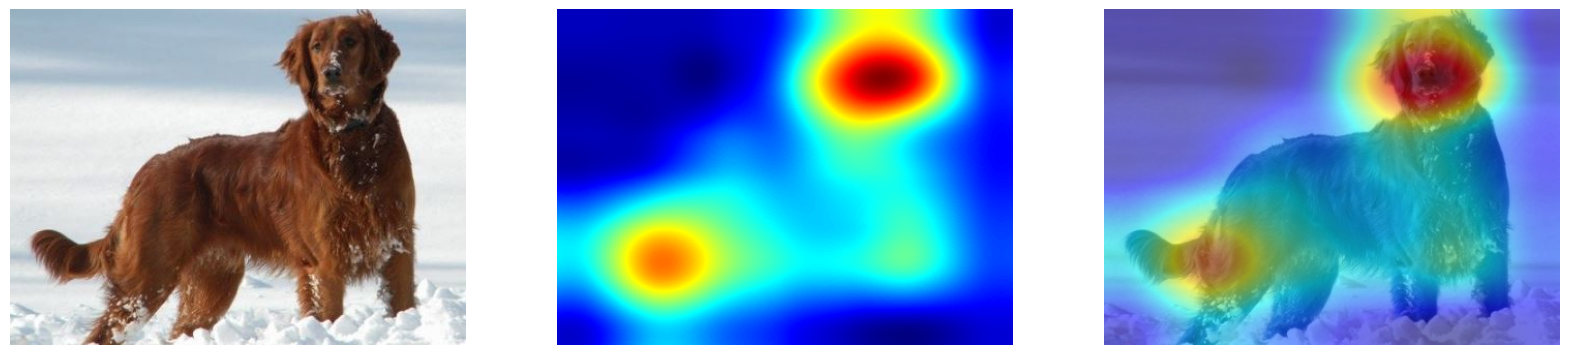

In [ ]:
f, ax = plt.subplots(1,3, figsize=(20, 10))

plt.axis('off');
ax[0].imshow(orig);
ax[1].imshow(heatmap);
ax[2].imshow(output);
[axi.set_axis_off() for axi in ax.ravel()];

## Now repeat the same steps for the ResNet50 model

## Try more examples

Now lets see what happens when we have two classes in one image (cat and dog)

## VGG16 Explanation

In [ ]:
!wget -O cat_dog.png https://i.imgur.com/BlyglPM.png

For our second image, if you implemented things correctly, it will look like our VGG16 model pays more attention to the dog than the cat. Woof woof! Try the same with the other model. What do you see?

## Try a ResNet50 Interpretation

## Now try to visualize what VGG16 sees for the same image as a cat

Hint: Use classIdx of 281

In [ ]:
vgg_gc = GradCAM(<...FILL IN CODE...>)

<...YOUR CODE HERE...>

## Bias in Datasets

Try to run the following image through both the models, what do you see?

In [ ]:
!wget -O train.png https://i.imgur.com/UAKXs0e.png

### VGG16 Explanation

### ResNet50 Explanation